# Terran building formation solver using cython, featuring flood fill and convolution algorithms.

#### See `placement_manager._solve_terran_building_formation()` for full building formation logic.

In [1]:
import sys
import lzma
from s2clientprotocol.sc2api_pb2 import Response, ResponseObservation
from MapAnalyzer.utils import import_bot_instance
from MapAnalyzer import MapData
import pickle
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../src")
sys.path.append("../src/ares")
from sc2.position import Point2
%load_ext line_profiler
%load_ext Cython

C:\Users\Tom\AppData\Local\pypoetry\Cache\virtualenvs\ares-sc2-S437wHWG-py3.9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BERLINGRAD = "../tests/pickle_data/BerlingradAIE.xz"

In [3]:
with lzma.open(BERLINGRAD, "rb") as f:
    raw_game_data, raw_game_info, raw_observation = pickle.load(f)
bot = import_bot_instance(raw_game_data, raw_game_info, raw_observation)
data = MapData(bot)

2023-05-13 19:26:31.626 | INFO     | MapAnalyzer.MapData:__init__:122 - dev Compiling Berlingrad AIE 
 Version dev Map Compilation Progress : 0.4it [00:00,  1.58it/s]


# FLOOD FILL

Alternative - `%%cython --annotate`

In [4]:
start_point=bot.enemy_start_locations[0].rounded
terrain_grid=bot.game_info.terrain_height.data_numpy.T
pathing_grid=data.get_pyastar_grid().astype(np.uint8)
max_distance=20
choke_points=set([point for ch in data.map_chokes for point in ch.points])

In [7]:
%%cython
from cython cimport boundscheck, wraparound

cdef unsigned int euclidean_distance_squared_int((unsigned int, unsigned int) p1, (unsigned int, unsigned int) p2):
    return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2

cpdef set flood_fill(
    (unsigned int, unsigned int) start_point, 
    const unsigned char[:, :] terrain_grid, 
    const unsigned char[:, :] pathing_grid, 
    unsigned int max_distance, 
    set choke_points
):
    cdef:
        unsigned int terrain_height = terrain_grid[start_point[0], start_point[1]]
        unsigned int pathing_value = pathing_grid[start_point[0], start_point[1]]
        set filled_points = set()

    # Only continue if we can get a height for the starting point
    if not terrain_height:
        return filled_points
    
    if pathing_value != 1:
        return filled_points
        
    grid_flood_fill(start_point, terrain_grid, pathing_grid, terrain_height, filled_points, start_point, max_distance, choke_points)
    return filled_points

cdef set grid_flood_fill(
    (unsigned int, unsigned int) point, 
    const unsigned char[:, :] terrain_grid, 
    const unsigned char[:, :] pathing_grid, 
    unsigned int target_val, 
    set current_vec, 
    (unsigned int, unsigned int) start_point, 
    unsigned int max_distance, 
    set choke_points):
    cdef:
        unsigned int terrain_height = terrain_grid[start_point[0], start_point[1]]
        unsigned int pathing_value = pathing_grid[start_point[0], start_point[1]]
    # Check that we haven't already added this point.
    if point in current_vec:
        return current_vec

    # Check that this point isn't too far away from the start
    if euclidean_distance_squared_int(point, start_point) > max_distance ** 2:
        return current_vec

    if point in choke_points:
        return current_vec

    terrain_height = terrain_grid[point[0], point[1]]
    pathing_value = pathing_grid[point[0], point[1]]
    if terrain_height != target_val or pathing_value != 1:
        return current_vec
    
    current_vec.add(point)
    grid_flood_fill((point[0]+1, point[1]), terrain_grid, pathing_grid, terrain_height, current_vec, start_point, max_distance, choke_points)
    grid_flood_fill((point[0]-1, point[1]), terrain_grid, pathing_grid, terrain_height, current_vec, start_point, max_distance, choke_points)
    grid_flood_fill((point[0], point[1]+1), terrain_grid, pathing_grid, terrain_height, current_vec, start_point, max_distance, choke_points)
    grid_flood_fill((point[0], point[1]-1), terrain_grid, pathing_grid, terrain_height, current_vec, start_point, max_distance, choke_points)

In [8]:
%timeit -r 1000 -n 5 flood_fill(start_point, terrain_grid, pathing_grid, max_distance, choke_points)

314 µs ± 9.62 µs per loop (mean ± std. dev. of 1000 runs, 5 loops each)


In [9]:
%prun -s cumulative flood_fill(start_point, terrain_grid, pathing_grid, max_distance, choke_points)

         60 function calls in 0.001 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.001    0.001 {built-in method builtins.exec}
        1    0.000    0.000    0.001    0.001 <string>:1(<module>)
        1    0.001    0.001    0.001    0.001 {built-in method _cython_magic_555d3061e85bd04edd4ce018b1179997.flood_fill}
        8    0.000    0.000    0.000    0.000 position.py:136(__eq__)
        8    0.000    0.000    0.000    0.000 {built-in method builtins.all}
       24    0.000    0.000    0.000    0.000 position.py:138(<genexpr>)
       16    0.000    0.000    0.000    0.000 {built-in method builtins.abs}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

In [10]:
%lprun -f flood_fill flood_fill(start_point, terrain_grid, pathing_grid, max_distance, choke_points)

C:\Users\Tom\AppData\Local\pypoetry\Cache\virtualenvs\ares-sc2-S437wHWG-py3.9\lib\site-packages\line_profiler\ipython_extension.py:71: UserWarning: Could not extract a code object for the object <built-in function flood_fill>
  profile = LineProfiler(*funcs)


Timer unit: 1e-07 s

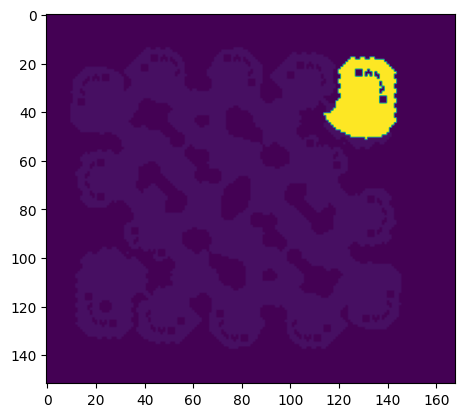

In [12]:
h = pathing_grid.copy()
for value in flood_fill(start_point, terrain_grid, pathing_grid, max_distance, choke_points):
    h[value] = 25
plt.imshow(h)

# Bounding Box

In [13]:
%%cython
from cython cimport boundscheck, wraparound
# The boundscheck(False) decorator tells Cython that we know that we will not access elements outside the bounds of the units list, which allows for faster indexing. 
# The wraparound(False) decorator tells Cython that we know that we will not use negative indices to access elements of the list, which also allows for faster indexing.
@boundscheck(False)
@wraparound(False)
cpdef ((float, float), (float, float)) get_bounding_box(set coordinates):
    cdef:
        float x_min = 9999.0
        float x_max = 0.0
        float x_val = 0.0
        float y_min = 9999.0
        float y_max = 0.0
        float y_val = 0.0
        int start = 0
        int stop = len(coordinates)
        (float, float) position
    for i in range(start, stop):
        position = coordinates.pop()
        x_val = position[0]
        y_val = position[1]
        if x_val < x_min:
            x_min = x_val
        if x_val > x_max:
            x_max = x_val
        if y_val < y_min:
            y_min = y_val
        if y_val > y_max:
            y_max = y_val
    return (x_min, x_max), (y_min, y_max)

In [14]:
%timeit -r 1000 -n 10 get_bounding_box(flood_fill(start_point, terrain_grid, pathing_grid, max_distance, choke_points))

340 µs ± 7.18 µs per loop (mean ± std. dev. of 1000 runs, 10 loops each)


In [15]:
raw_x_bounds, raw_y_bounds = get_bounding_box(flood_fill(start_point, terrain_grid, pathing_grid, max_distance, choke_points))

# Find building locations with convolution pass

In [16]:
%%cython

from scipy.signal import convolve2d
import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cpdef bint can_place_structure(
    (int, int) building_origin,
    (int, int) building_size,
    const unsigned char[:, :] creep_grid,
    const unsigned char[:, :] placement_grid,
    const unsigned char[:, :] pathing_grid,
    bint avoid_creep = 1,
    bint include_addon = 0
):
    cdef:
        unsigned int size_x = building_size[0]
        unsigned int size_y = building_size[1]
        unsigned int x = building_origin[0]
        unsigned int y = building_origin[1]
        unsigned int total = 0
        unsigned int area = size_x * size_y
        unsigned int creep_check = 1 if avoid_creep else 0
    
    cdef Py_ssize_t i, j
    for i in range(size_y):
        for j in range(size_x):
            if placement_grid[y + i, x + j] == 0:
                return 0
            if creep_grid[y + i, x + j] == creep_check:
                return 0
            if pathing_grid[y + i, x + j] == 1:
                return 0
    return 1

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cpdef list find_building_locations(
    np.ndarray[np.uint8_t, ndim=2] kernel,
    unsigned int x_stride,
    unsigned int y_stride,
    (unsigned int, unsigned int) x_bounds,
    (unsigned int, unsigned int) y_bounds,
    const unsigned char[:, :] creep_grid,
    const unsigned char[:, :] placement_grid,
    const unsigned char[:, :] pathing_grid,
    const unsigned char[:, :] points_to_avoid_grid,
    unsigned int building_width,
    unsigned int building_height,
    bint avoid_creep = 1,
    bint include_addon = 0
):
    """
    Use a convolution pass to find all possible building locations in an area
    See full docs in `placement_solver.pyi`
    """
    cdef:
        # unsigned int i = 0
        # unsigned int j = 0
        unsigned int _x = 0
        unsigned int _y = 0
        unsigned int valid_idx = 0
        float x, y
        float weighted_x, weighted_y
        int x_min = x_bounds[0]
        int x_max = x_bounds[1]
        int y_min = y_bounds[0]
        int y_max = y_bounds[1]
        unsigned char[:, :] to_convolve = np.ones((x_max - x_min + 1, y_max - y_min + 1), dtype=np.uint8)
        (float, float) [500] valid_spots
        (float, float) center
        float half_width = building_width / 2
        cdef bint avoid = 0
    
    cdef Py_ssize_t i, j
    for i in range(x_min, x_max + 1):
        for j in range(y_min, y_max + 1):
            if points_to_avoid_grid[j][i] == 0 and creep_grid[j][i] == 0 and placement_grid[j][i] == 1 and pathing_grid[j][i] == 1:
                to_convolve[i - x_min][j - y_min] = 0

    cdef unsigned char[:, :] result = convolve2d(to_convolve, kernel, mode="valid")
    cdef Py_ssize_t k, l
    
    for i in range(0, result.shape[0], x_stride):
        for j in range(0, result.shape[1], y_stride):
            if result[i][j] == 0:
                x = i + x_min + half_width
                y = j + y_min + half_width

                if include_addon:
                    _x = int(x + 1.5)
                    _y = int(y + 0.5)
                    if not can_place_structure((_x, _y), (2, 2), creep_grid, placement_grid, pathing_grid, avoid_creep):
                        continue
                    
                    avoid = 0
                    for k in range(2):
                        for l in range(2):
                            if points_to_avoid_grid[_y+k, _x+l]:
                                avoid = 1
                    if avoid:
                        continue

                # valid building placement is building center, so add half to x and y
                valid_spots[valid_idx][0] = x
                valid_spots[valid_idx][1] = y
                valid_idx += 1

    if valid_idx == 0:
        return []

    return list(valid_spots)[:valid_idx]

In [17]:
kernel: np.ndarray = np.ones(
            (3, 3), dtype=np.uint8
        )

points_to_avoid_grid = np.zeros(bot.game_info.placement_grid.data_numpy.shape, dtype=np.uint8)

# avoid within 5.5 distance of base location
start_x = int(bot.townhalls[0].position.x - 5.5)
start_y = int(bot.townhalls[0].position.y - 5.5)

points_to_avoid_grid[start_x:start_x+11, start_y:start_y+11] = 1

production_positions = find_building_locations(
    kernel, 
    5,
    3,
    raw_x_bounds, 
    raw_y_bounds, 
    bot.state.creep.data_numpy, 
    bot.game_info.placement_grid.data_numpy,
    data.get_pyastar_grid().astype(np.uint8).T,
    # bot.game_info.pathing_grid.data_numpy, 
    points_to_avoid_grid, 
    3, 
    3,
    True
)
print(production_positions)

[(24.5, 139.5), (29.5, 127.5), (29.5, 130.5), (29.5, 133.5), (34.5, 124.5), (34.5, 127.5), (34.5, 130.5), (34.5, 133.5), (39.5, 121.5), (39.5, 124.5), (39.5, 127.5), (39.5, 130.5), (39.5, 133.5), (39.5, 136.5), (39.5, 139.5), (44.5, 118.5), (44.5, 121.5), (44.5, 124.5), (44.5, 127.5), (44.5, 130.5), (44.5, 133.5), (44.5, 136.5), (44.5, 139.5), (49.5, 121.5), (49.5, 124.5), (49.5, 127.5), (49.5, 130.5), (49.5, 133.5), (49.5, 136.5), (49.5, 139.5)]


In [18]:
%timeit -r 1000 -n 10 can_place_structure((25, 25), (3, 3), bot.state.creep.data_numpy, bot.game_info.placement_grid.data_numpy, pathing_grid)

The slowest run took 17.90 times longer than the fastest. This could mean that an intermediate result is being cached.
1.24 µs ± 633 ns per loop (mean ± std. dev. of 1000 runs, 10 loops each)


In [19]:
%timeit -r 1000 -n 10 find_building_locations(kernel, 5,3, raw_x_bounds, raw_y_bounds, bot.state.creep.data_numpy, bot.game_info.placement_grid.data_numpy, pathing_grid, points_to_avoid_grid, 3, 3,True)

63.3 µs ± 2.66 µs per loop (mean ± std. dev. of 1000 runs, 10 loops each)


## Example of how placement locations could be stored

In [20]:
placements_dict = dict()

In [21]:
placements_dict[bot.townhalls[0].position] = {}
placements_dict[bot.townhalls[0].position]["3x3"] = {}
for pos in production_positions:
    x: float = pos[0]
    y: float = pos[1]
    point2_pos: Point2 = Point2((x, y))
    placements_dict[bot.townhalls[0].position]["3x3"][point2_pos] = {
                        "available": True,
                        "has_addon": False,
                        "is_wall": False,
                        "tag": 0, # structure tag if not available
                        "worker_on_route": False # available but recently requested
                    }
placements_dict[Point2((300.0, 300.0))] = {}

In [22]:
placements_dict

{(120.5,
  24.5): {'3x3': {(24.5, 139.5): {'available': True,
    'has_addon': False,
    'is_wall': False,
    'tag': 0,
    'worker_on_route': False},
   (29.5, 127.5): {'available': True,
    'has_addon': False,
    'is_wall': False,
    'tag': 0,
    'worker_on_route': False},
   (29.5, 130.5): {'available': True,
    'has_addon': False,
    'is_wall': False,
    'tag': 0,
    'worker_on_route': False},
   (29.5, 133.5): {'available': True,
    'has_addon': False,
    'is_wall': False,
    'tag': 0,
    'worker_on_route': False},
   (34.5, 124.5): {'available': True,
    'has_addon': False,
    'is_wall': False,
    'tag': 0,
    'worker_on_route': False},
   (34.5, 127.5): {'available': True,
    'has_addon': False,
    'is_wall': False,
    'tag': 0,
    'worker_on_route': False},
   (34.5, 130.5): {'available': True,
    'has_addon': False,
    'is_wall': False,
    'tag': 0,
    'worker_on_route': False},
   (34.5, 133.5): {'available': True,
    'has_addon': False,
    'is_wal